In [1]:
import torch
import os
import json
from torch.nn import CosineSimilarity
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM, LlamaTokenizer
from functools import partial
from baukit import TraceDict
from einops import rearrange, einsum
from collections import defaultdict
import matplotlib.pyplot as plt
from plotly_utils import imshow, scatter
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import math
import seaborn as sns
from peft import PeftModel
import pickle

import pysvelte
import analysis_utils
from counterfactual_datasets.entity_tracking import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
transformers.set_seed(seed)

%load_ext autoreload
%autoreload 2

In [2]:
print("Model Loading...")
# path = "AlekseyKorshuk/vicuna-7b"
# path = "/data/nikhil_prakash/goat-finetuning/drawn-moon-15/"
path = "/data/nikhil_prakash/llama_weights/7B"
# tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForCausalLM.from_pretrained(path).to(device)

# base_model = "decapoda-research/llama-7b-hf"
# lora_weights = "tiedong/goat-lora-7b"

tokenizer = LlamaTokenizer.from_pretrained(
    "hf-internal-testing/llama-tokenizer", padding_side="right"
)
# model = LlamaForCausalLM.from_pretrained(
#     base_model,
#     load_in_8bit=False,
#     torch_dtype=torch.float32,
#     device_map="auto",
# )
# model = PeftModel.from_pretrained(
#     model,
#     lora_weights,
#     torch_dtype=torch.float32,
#     device_map={"": 0},
# )

tokenizer.pad_token_id = tokenizer.eos_token_id
# llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id

Model Loading...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Evaluating Models

In [37]:
data_file = "./box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "./box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [38]:
raw_data = entity_tracking_example_sampler(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
    # object_file=object_file,
    few_shot=False,
    alt_examples=True,
    # num_ents_or_ops=3,
    architecture="LLaMAForCausalLM",
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


In [40]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)
print(f"Answer: {tokenizer.decode(dataset[idx]['labels'])}")

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the
Answer: document


In [41]:
total_count = 0
correct_count = 0
model.eval()
errors = defaultdict(int)
with torch.no_grad():
    for _, output in tqdm(enumerate(tqdm(dataloader))):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        outputs = model(input_ids=output["input_ids"])

        for bi in range(output["labels"].size(0)):
            label = output["labels"][bi]
            pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
            box_label = output["input_ids"][bi][output["last_token_indices"][bi] - 2]
            prev_box_label_pos = output["input_ids"][bi].eq(box_label).nonzero()[:, 0][0].item()
            prev_box_label_index = prev_box_label_pos // 8 + 1

            if label == pred:
                correct_count += 1
            else:
                errors[prev_box_label_index] += 1
                # print(prev_box_label_pos, prev_box_label_index)
                # print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
            total_count += 1

del outputs
torch.cuda.empty_cache()

current_acc = round(correct_count / total_count, 2)
print(f"Task accuracy: {current_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:20<00:00,  2.05s/it]
10it [00:20,  2.05s/it]

Task accuracy: 0.66


## Loading Counterfactual Data

In [3]:
num_boxes = 7
raw_data = box_index_aligner_examples(
    tokenizer,
    num_samples=100,
    data_file=f"./box_datasets/no_instructions/alternative/Random/{num_boxes}/train.jsonl",
    # object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    few_shot=False,
    alt_examples=True,
    num_ents_or_ops=num_boxes,
)

In [4]:
base_tokens = raw_data[0]
base_last_token_indices = raw_data[1]
source_tokens = raw_data[2]
source_last_token_indices = raw_data[3]
correct_answer_token = raw_data[4]
# incorrect_answer_token = raw_data[6]

base_tokens = torch.cat([t.unsqueeze(dim=0) for t in base_tokens], dim=0).to(device)
source_tokens = torch.cat([t.unsqueeze(dim=0) for t in source_tokens], dim=0).to(device)

In [29]:
for i in range(-6, -1):
    print(tokenizer.decode(raw_data[0][i][: raw_data[1][i] + 1]))
    print(tokenizer.decode(raw_data[2][i][: raw_data[3][i] + 1]))
    print(tokenizer.decode(raw_data[4][i]))
    print()

<s>The apple is in Box G, the shell is in Box M, the car is in Box X, the card is in Box N, the bill is in Box P, the clock is in Box B, the pot is in Box Y. Box N contains the
<s>The bomb is in Box T, the television is in Box D, the shell is in Box L, the ticket is in Box Q, the document is in Box B, the mirror is in Box C, the magnet is in Box G. Box N contains the
card

<s>The apple is in Box G, the shell is in Box M, the car is in Box X, the card is in Box N, the bill is in Box P, the clock is in Box B, the pot is in Box Y. Box P contains the
<s>The pot is in Box U, the flower is in Box D, the car is in Box K, the disk is in Box C, the fan is in Box H, the bill is in Box S, the painting is in Box L. Box Q contains the
bill

<s>The apple is in Box G, the shell is in Box M, the car is in Box X, the card is in Box N, the bill is in Box P, the clock is in Box B, the pot is in Box Y. Box B contains the
<s>The bomb is in Box T, the television is in Box D, the shell is in Box L, the ticke

## Implementing Path Patching

In [30]:
hook_points = [
    f"model.layers.{layer}.self_attn.o_proj" for layer in range(model.config.num_hidden_layers)
]

# hook_points += [f"model.layers.{layer}.mlp" for layer in range(model.config.num_hidden_layers)]

with torch.no_grad():
    # Step 1
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as clean_cache:
        _ = model(base_tokens)

    with TraceDict(
        model,
        hook_points,
        retain_input=True,
    ) as corrupt_cache:
        _ = model(source_tokens)

In [31]:
def patching_heads(
    inputs,
    output,
    layer,
    sender_layer,
    sender_head,
    clean_last_token_indices,
    corrupt_last_token_indices,
    rel_pos,
):
    """
    rel_pos: Represents the token position relative to the "real" (non-padded) last token in the sequence. All the heads at this position and subsequent positions need to patched from clean run, except the sender head at this position.
    """

    input = inputs[0]
    batch_size = input.size(0)

    if "o_proj" in layer:
        input = rearrange(
            input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        clean_head_outputs = rearrange(
            clean_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )
        corrupt_head_outputs = rearrange(
            corrupt_cache[layer].input,
            "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
            n_heads=model.config.num_attention_heads,
        )

        layer = int(layer.split(".")[2])
        if sender_layer == layer:
            for bi in range(batch_size):
                if rel_pos == -1:
                    # Computing the previous query box label token position
                    clean_prev_box_label_pos = analysis_utils.compute_prev_query_box_pos(
                        base_tokens[bi], clean_last_token_indices[bi]
                    )
#                     corrupt_prev_box_label_pos = analysis_utils.compute_prev_query_box_pos(
#                         source_tokens[bi], corrupt_last_token_indices[bi]
#                     )

                    # Since, queery box may not present in the corrupt prompt, patch in
                    # the output of heads from any random box label token
                    corrupt_prev_box_label_pos = random.choice(range(6, 49, 7))
                else:
                    clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos
                    corrupt_prev_box_label_pos = corrupt_last_token_indices[bi] - rel_pos

                for pos in range(clean_prev_box_label_pos, clean_last_token_indices[bi] + 1):
                    for head_ind in range(model.config.num_attention_heads):
                        if head_ind == sender_head and pos == clean_prev_box_label_pos:
                            input[bi, pos, sender_head] = corrupt_head_outputs[
                                bi, corrupt_prev_box_label_pos, sender_head
                            ]
                        else:
                            input[bi, pos, head_ind] = clean_head_outputs[bi, pos, head_ind]

        else:
            for bi in range(batch_size):
                if rel_pos == -1:
                    # Computing the previous query box label token position
                    clean_prev_box_label_pos = analysis_utils.compute_prev_query_box_pos(
                        base_tokens[bi], clean_last_token_indices[bi]
                    )
                else:
                    clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos

                for pos in range(clean_prev_box_label_pos, clean_last_token_indices[bi] + 1):
                    input[bi, pos] = clean_head_outputs[bi, pos]

        input = rearrange(
            input,
            "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
            n_heads=model.config.num_attention_heads,
        )

        w_o = model.model.layers[layer].self_attn.o_proj.weight
        output = einsum(
            input,
            w_o,
            "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
        )

    return output

In [32]:
def patching_receiver_heads(
    output, layer, patched_cache, receiver_heads, clean_last_token_indices, rel_pos
):
    batch_size = output.size(0)
    receiver_heads_in_curr_layer = [h for l, h in receiver_heads if l == int(layer.split(".")[2])]

    output = rearrange(
        output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    patched_head_outputs = rearrange(
        patched_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    # Patch in the output of the receiver heads from patched run
    for receiver_head in receiver_heads_in_curr_layer:
        for bi in range(batch_size):
            if rel_pos == -1:
                # Computing the previous query box label token position
                clean_prev_box_label_pos = analysis_utils.compute_prev_query_box_pos(
                    base_tokens[bi], clean_last_token_indices[bi]
                )
            else:
                clean_prev_box_label_pos = clean_last_token_indices[bi] - rel_pos

            output[bi, clean_prev_box_label_pos, receiver_head] = patched_head_outputs[
                bi, clean_prev_box_label_pos, receiver_head
            ]

    output = rearrange(
        output,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )

    return output

In [33]:
receiver_heads = heads_at_query_box_pos

receiver_layers = list(
    set([f"model.layers.{layer}.self_attn.v_proj" for layer, _ in receiver_heads])
)

# receiver_heads = [[layer, head] for layer, head in [[21, 3]]]

print(receiver_layers)
print(receiver_heads)

['model.layers.9.self_attn.v_proj', 'model.layers.13.self_attn.v_proj', 'model.layers.10.self_attn.v_proj', 'model.layers.7.self_attn.v_proj', 'model.layers.1.self_attn.v_proj', 'model.layers.6.self_attn.v_proj', 'model.layers.5.self_attn.v_proj', 'model.layers.12.self_attn.v_proj', 'model.layers.4.self_attn.v_proj', 'model.layers.8.self_attn.v_proj', 'model.layers.11.self_attn.v_proj']
[[10, 3], [13, 14], [9, 2], [11, 23], [1, 9], [9, 7], [9, 10], [7, 17], [11, 24], [7, 26], [4, 4], [13, 0], [6, 10], [7, 9], [5, 7], [12, 0], [8, 1], [9, 29], [12, 9], [7, 3], [11, 7], [12, 23], [9, 15], [10, 21], [9, 21], [10, 4], [10, 7], [13, 26], [13, 12], [8, 12]]


In [34]:
path_patching_logits = torch.zeros(
    model.config.num_hidden_layers, model.config.num_attention_heads
).to(device)
batch_size = base_tokens.size(0)
apply_softmax = torch.nn.Softmax(dim=-1)

for layer in tqdm(range(model.config.num_hidden_layers)):
    for head in range(model.config.num_attention_heads):
        with torch.no_grad():
            # Step 2
            with TraceDict(
                model,
                hook_points + receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_heads,
                    sender_layer=layer,
                    sender_head=head,
                    clean_last_token_indices=base_last_token_indices,
                    corrupt_last_token_indices=source_last_token_indices,
                    rel_pos=-1,
                ),
            ) as patched_cache:
                _ = model(base_tokens)

            # Step 3
            with TraceDict(
                model,
                receiver_layers,
                retain_input=True,
                edit_output=partial(
                    patching_receiver_heads,
                    patched_cache=patched_cache,
                    receiver_heads=receiver_heads,
                    clean_last_token_indices=base_last_token_indices,
                    rel_pos=-1,
                ),
            ) as _:
                patched_out = model(base_tokens)

            for bi in range(batch_size):
                logits = apply_softmax(patched_out.logits[bi, base_last_token_indices[bi]])
                path_patching_logits[layer, head] += (logits[correct_answer_token[bi]]).item()

            path_patching_logits[layer, head] = path_patching_logits[layer, head] / batch_size

del patched_out
torch.cuda.empty_cache()

100%|██████████| 32/32 [3:09:27<00:00, 355.23s/it]  


In [35]:
torch.save(path_patching_logits, "./new_pp_exps/post_submission/llama-7b/heads_at_prev_query_box_pos.pt")

In [36]:
heads_at_prev_query_box_pos = analysis_utils.compute_topk_components(
    path_patching_logits, k=30,largest=False
)
print(f"Head influencing object info fetcher heads: {heads_at_prev_query_box_pos}")

Head influencing object info fetcher heads: [[8, 21], [12, 23], [11, 9], [11, 23], [8, 12], [9, 21], [10, 6], [6, 23], [12, 13], [12, 29], [12, 30], [7, 0], [9, 30], [7, 14], [11, 28], [10, 24], [6, 31], [9, 14], [5, 1], [8, 28], [0, 18], [6, 14], [9, 10], [4, 20], [7, 16], [12, 25], [8, 26], [9, 9], [12, 15], [7, 20]]


In [22]:
# path_patching_logits = torch.load("./new_pp_exps/reverse/7_boxes_llama_post_submission/heads_at_query_box_pos.pt")
# imshow(
#     (path_patching_logits - torch.mean(path_patching_logits)) / torch.std(path_patching_logits),
#     # title="Heads affecting value vector of head (11, 23) at box label position",
#     yaxis_title="Layer",
#     xaxis_title="Head",
# )

direct_logit_heads = analysis_utils.compute_topk_components(
    path_patching_logits, k=50, largest=False
)
print(f"Head influencing object info fetcher heads: {direct_logit_heads}")

Head influencing object info fetcher heads: [[14, 27], [16, 2], [15, 13], [21, 3], [11, 23], [15, 18], [30, 4], [18, 8], [13, 1], [29, 7], [17, 26], [24, 5], [18, 3], [12, 23], [19, 12], [17, 28], [20, 14], [23, 15], [14, 0], [21, 4], [15, 5], [23, 5], [28, 17], [19, 30], [17, 27], [13, 0], [23, 20], [18, 28], [24, 8], [15, 2], [15, 6], [31, 25], [21, 26], [19, 2], [23, 30], [21, 25], [21, 0], [31, 26], [14, 13], [18, 20], [17, 3], [16, 16], [13, 14], [23, 17], [28, 16], [14, 11], [16, 27], [19, 8], [23, 16], [15, 9]]


In [23]:
logits = torch.load("./new_pp_exps/reverse/final_7_boxes/direct_logit_heads.pt")
# imshow(
#     (path_patching_logits - torch.mean(path_patching_logits)) / torch.std(path_patching_logits),
#     # title="Heads affecting value vector of head (11, 23) at box label position",
#     yaxis_title="Layer",
#     xaxis_title="Head",
# )

direct_logit_heads = analysis_utils.compute_topk_components(
    logits, k=50, largest=False
)
print(f"Head influencing object info fetcher heads: {direct_logit_heads}")

Head influencing object info fetcher heads: [[14, 27], [16, 2], [15, 13], [21, 3], [15, 18], [11, 23], [30, 4], [18, 8], [24, 5], [17, 26], [29, 7], [13, 1], [18, 3], [12, 23], [23, 15], [20, 14], [17, 28], [14, 0], [19, 12], [21, 4], [15, 5], [23, 5], [17, 27], [13, 0], [28, 17], [19, 30], [24, 8], [18, 28], [23, 20], [19, 2], [15, 6], [31, 26], [21, 25], [15, 2], [17, 3], [31, 25], [18, 20], [23, 30], [14, 13], [23, 17], [21, 0], [13, 14], [28, 16], [16, 16], [23, 19], [14, 11], [21, 26], [31, 29], [19, 8], [16, 27]]


In [239]:
imshow(
    (path_patching_logits - torch.mean(path_patching_logits)) / torch.std(path_patching_logits),
    # title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_q_comp_with_heads_at_query_box_pos = analysis_utils.compute_topk_components(
    path_patching_logits, k=20, largest=False
)
print(f"Head influencing object info fetcher heads: {heads_q_comp_with_heads_at_query_box_pos}")

Head influencing object info fetcher heads: [[10, 3], [11, 23], [9, 2], [7, 17], [9, 21], [12, 9], [11, 24], [4, 4], [4, 19], [7, 14], [8, 31], [8, 10], [12, 0], [9, 7], [12, 23], [8, 7], [1, 22], [7, 27], [8, 29], [11, 9]]


In [174]:
torch.save(
    path_patching_logits,
    "./new_pp_exps/reverse/new_counterfactual/heads_q_comp_with_heads_at_query_box_pos.pt",
)

## Num of Heads Searching

In [3]:
with open("num_heads_results.json", "r") as f:
    num_heads_results = json.load(f)

In [8]:
for heads_comb, acc in num_heads_results.items():
    if acc >= 0.61:
        heads_comb = [int(h) for h in heads_comb[1:-1].split(", ")]
        if sum(heads_comb) <= 100:
            print(f"Heads combination: {heads_comb}, Accuracy: {acc}")

Heads combination: [47, 15, 25, 10], Accuracy: 0.61
Heads combination: [65, 0, 25, 10], Accuracy: 0.61
Heads combination: [60, 5, 25, 10], Accuracy: 0.61
Heads combination: [55, 10, 25, 10], Accuracy: 0.61


## Circuit Analysis

### Alternative

In [147]:
original_logits = 0
apply_softmax = torch.nn.Softmax(dim=-1)

with torch.no_grad():
    output = model(base_tokens)
    for bi in range(base_tokens.size(0)):
        logits = apply_softmax(output.logits[bi, base_last_token_indices[bi]])
        original_logits += (logits[correct_answer_token[bi]]).item()

    original_logits = original_logits / batch_size

del output
torch.cuda.empty_cache()

In [58]:
path = "./new_pp_exps/reverse/5_boxes/direct_logit_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - torch.mean(logit_values)) / torch.std(logit_values),
    title="Heads influencing final logit",
    yaxis_title="Layer",
    xaxis_title="Head",
)

direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=20, largest=False)
print(f"Head influencing final logit: {direct_logit_heads}")

Head influencing final logit: [[21, 3], [15, 13], [30, 4], [21, 4], [18, 8], [15, 18], [23, 15], [20, 14], [17, 28], [29, 7], [23, 20], [18, 3], [14, 27], [24, 8], [23, 19], [18, 20], [28, 17], [17, 27], [18, 28], [24, 5]]


In [149]:
patching_values = torch.load("./new_pp_exps/reverse/heads_affecting_direct_logit_heads_new.pt")

imshow(
    (patching_values - original_logits) / original_logits,
    title="Heads affecting query vector of value fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_value_fetcher_heads = analysis_utils.compute_topk_components(
    patching_values, 5, largest=False
)

print(heads_influencing_value_fetcher_heads)

[[14, 27], [11, 23], [12, 23], [14, 13], [13, 25]]


In [193]:
patching_values = torch.load(
    "/home/local_nikhil/Projects/Anima-2.0/new_pp_exps/reverse/heads_v_comp_at_query_box_token_pos.pt"
)

imshow(
    (patching_values - original_logits) / original_logits,
    title="Heads affecting query vector of value fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_query_box_pos = analysis_utils.compute_topk_components(patching_values, 5, largest=False)

print(heads_at_query_box_pos)

[[13, 14], [10, 3], [9, 10], [11, 23], [9, 2]]


### Original

In [7]:
original_logits = 0
apply_softmax = torch.nn.Softmax(dim=-1)

with torch.no_grad():
    output = model(base_tokens)
    for bi in range(base_tokens.size(0)):
        logits = apply_softmax(output.logits[bi, base_last_token_indices[bi]])
        original_logits += (logits[correct_answer_token[bi]]).item()

    original_logits = original_logits / batch_size

del output
torch.cuda.empty_cache()

In [15]:
path = "./new_pp_exps/forward/direct_logit_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads influencing final logit",
    yaxis_title="Layer",
    xaxis_title="Head",
)

direct_logit_heads = analysis_utils.compute_topk_components(logit_values, k=20, largest=False)
print(f"Head influencing final logit: {direct_logit_heads}")

Head influencing final logit: [[21, 3], [28, 17], [15, 13], [14, 11], [29, 7], [23, 19], [14, 24], [23, 24], [18, 3], [24, 7], [24, 5], [30, 4], [15, 5], [13, 25], [18, 8], [18, 28], [19, 8], [17, 26], [24, 11], [23, 20]]


In [129]:
path = "./new_pp_exps/forward/heads_q_comp_with_direct_logit_heads.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting query vector of object fetcher heads",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_influencing_object_value_fetcher_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing object info fetcher heads: {heads_influencing_object_value_fetcher_heads}")

Head influencing object info fetcher heads: [[14, 27], [11, 23], [12, 23], [13, 25], [13, 1], [15, 13], [19, 12], [9, 0], [16, 2], [10, 6]]


In [10]:
path = "./new_pp_exps/forward/heads_k_comp_with_object_fetcher_at_correct_pos_new.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting key vector of object value fetcher heads at correct token position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_correct_obj_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=5, largest=False
)
print(
    f"Head in K-composition with value fetcher heads at correct token position: {heads_at_correct_obj_pos}"
)

Head in K-composition with value fetcher heads at correct token position: [[8, 21], [16, 22], [14, 0], [11, 11], [11, 26]]


In [9]:
path = "./new_pp_exps/forward/heads_v_comp_at_contains_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    # title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_contains_pos = analysis_utils.compute_topk_components(
    torch.load(path), k=10, largest=False
)
print(f"Head influencing object info fetcher heads: {heads_at_contains_pos}")

Head influencing object info fetcher heads: [[7, 27], [7, 29], [7, 25], [10, 6], [0, 1], [13, 1], [8, 12], [5, 1], [12, 14], [12, 23]]


In [17]:
path = "./new_pp_exps/forward/heads_v_comp_with_11_23_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (11, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_at_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_at_box_pos}")

Head influencing object info fetcher heads: [[10, 3], [9, 2], [9, 10], [9, 21], [8, 12]]


In [18]:
path = "./new_pp_exps/forward/heads_v_comp_12_23_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (12, 23) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_v_comp_12_23 = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_v_comp_12_23}")

Head influencing object info fetcher heads: [[10, 3], [10, 17], [11, 24], [9, 7], [9, 21]]


In [19]:
path = "./new_pp_exps/forward/heads_v_comp_with_14_27_label_pos.pt"
logit_values = torch.load(path)

imshow(
    (logit_values - original_logits) / original_logits,
    title="Heads affecting value vector of head (14, 27) at box label position",
    yaxis_title="Layer",
    xaxis_title="Head",
)

heads_v_comp_14_27 = analysis_utils.compute_topk_components(torch.load(path), k=5, largest=False)
print(f"Head influencing object info fetcher heads: {heads_v_comp_14_27}")

Head influencing object info fetcher heads: [[13, 25], [10, 3], [13, 14], [11, 23], [9, 10]]


## Verifying Positional Information

### Loading Data

In [145]:
value_exps = object_alignment_example_sampler(
    tokenizer,
    num_samples=180,
    data_file="./box_datasets/no_instructions/original/3/train.jsonl",
    object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    num_ents_or_ops=3,
    few_shot=False,
    alt_examples=False,
)

org_tokens = value_exps[2]
org_last_token_indices = value_exps[3]
alt_tokens = value_exps[0]
alt_last_token_indices = value_exps[1]
correct_answer_token = value_exps[4]

org_tokens = torch.tensor(org_tokens).to(device)
alt_tokens = torch.tensor(alt_tokens).to(device)
correct_answer_token = torch.tensor(correct_answer_token).to(device)

In [153]:
positional_exps = shift_query_position_example_sampler(
    tokenizer,
    num_samples=180,
    data_file="./box_datasets/no_instructions/original/3/train.jsonl",
    object_file="./box_datasets/objects_with_bnc_frequency.csv",
    architecture="LLaMAForCausalLM",
    num_ents_or_ops=3,
    few_shot=False,
    alt_examples=False,
)

org_tokens = positional_exps[0]
org_last_token_indices = positional_exps[1]
alt_tokens = positional_exps[2]
alt_last_token_indices = positional_exps[3]
correct_answer_token = positional_exps[4]

org_tokens = torch.tensor(org_tokens).to(device)
alt_tokens = torch.tensor(alt_tokens).to(device)
correct_answer_token = torch.tensor(correct_answer_token).to(device)

In [154]:
for i in range(0, 5):
    print(tokenizer.decode(org_tokens[i][: org_last_token_indices[i] + 1]))
    print(tokenizer.decode(alt_tokens[i][: alt_last_token_indices[i] + 1]))
    print(tokenizer.decode(correct_answer_token[i]))
    print()

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 0 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 0 contains
 boot

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 1 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 1 contains
 l

 Box 0 contains boot, Box 1 contains lunchbox, Box 2 contains bell. Box 2 contains
 Box 1 contains lunchbox, Box 2 contains bell, Box 0 contains boot. Box 2 contains
 bell

 Box 0 contains stone, Box 1 contains cherimoya, Box 2 contains otamatone. Box 0 contains
 Box 1 contains cherimoya, Box 2 contains otamatone, Box 0 contains stone. Box 0 contains
 stone

 Box 0 contains stone, Box 1 contains cherimoya, Box 2 contains otamatone. Box 1 contains
 Box 1 contains cherimoya, Box 2 contains otamatone, Box 0 contains stone. Box 1 contains
 cher



### Activation Patching

In [155]:
# value_fetcher_heads = [[layer, head] for layer, head in heads_influencing_final_logit if layer > 15]
# value_fetcher_heads

In [156]:
heads_influencing_object_value_fetcher_heads

[[12, 20], [14, 11], [15, 13], [13, 25], [14, 27]]

In [157]:
hook_points = []
for l, h in heads_influencing_object_value_fetcher_heads:
    hook_points.append(f"model.layers.{l}.self_attn.o_proj")

hook_points = list(set(hook_points))

In [158]:
answer_logits = torch.zeros(org_tokens.size(0))
with torch.no_grad():
    output = model(org_tokens)
    logits = output.logits
    for bi in range(org_tokens.size(0)):
        answer_logits[bi] = logits[bi, org_last_token_indices[bi], correct_answer_token[bi]].item()

del output, logits
torch.cuda.empty_cache()

In [159]:
with torch.no_grad():
    with TraceDict(model, hook_points, retain_input=True) as alt_cache:
        _ = model(alt_tokens)

In [160]:
def activation_patching(
    inputs, output, layer, patching_heads, cache, input_last_pos, patch_last_pos
):
    input = inputs[0]

    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    patch = rearrange(
        cache[layer].input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    layer_index = int(layer.split(".")[2])
    heads = [h for l, h in patching_heads if l == layer_index]

    for bi in range(input.size(0)):
        for head in heads:
            input[bi, input_last_pos[bi], head] = patch[bi, patch_last_pos[bi], head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )

    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input,
        w_o,
        "batch seq_len d_model, hidden_size d_model -> batch seq_len d_model",
    )

    return output

In [161]:
with torch.no_grad():
    with TraceDict(
        model,
        hook_points,
        retain_input=True,
        edit_output=partial(
            activation_patching,
            patching_heads=heads_influencing_object_value_fetcher_heads,
            cache=alt_cache,
            input_last_pos=org_last_token_indices,
            patch_last_pos=alt_last_token_indices,
        ),
    ) as _:
        output = model(org_tokens)

    patched_answer_logits = torch.zeros(org_tokens.size(0))
    for bi in range(org_tokens.size(0)):
        logits = output.logits[bi, org_last_token_indices[bi]]
        patched_answer_logits[bi] = logits[correct_answer_token[bi]].item()

    print(
        f"Decrease in the answer logits: {round((patched_answer_logits - answer_logits).mean().item(), 2)}"
    )

del logits, output
torch.cuda.empty_cache()

Decrease in the answer logits: -2.1


In [336]:
del output, logits
torch.cuda.empty_cache()

## Visualizing Head Attention

In [8]:
with open("circuit_heads.json", "r") as file:
    circuit_heads = json.load(file)

In [18]:
layer = 9
attn_scores, value_vectors = analysis_utils.get_attn_scores(model, base_tokens, layer)

In [19]:
value_vectors_norm = torch.norm(value_vectors, dim=-1)
scaled_attn = einsum(
    value_vectors_norm,
    attn_scores,
    "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
)

In [39]:
index = 4
print(f"layer: {layer}, Bi: {index}")
pysvelte.AttentionMulti(
    tokens=[tokenizer.decode(token) for token in base_tokens[index].cpu().tolist()],
    attention=scaled_attn[index].permute(1, 2, 0).cpu(),
).show()

layer: 9, Bi: 4


## Ablation Experiments

### Ablating Correct Object Locator Heads in the Forward Setting

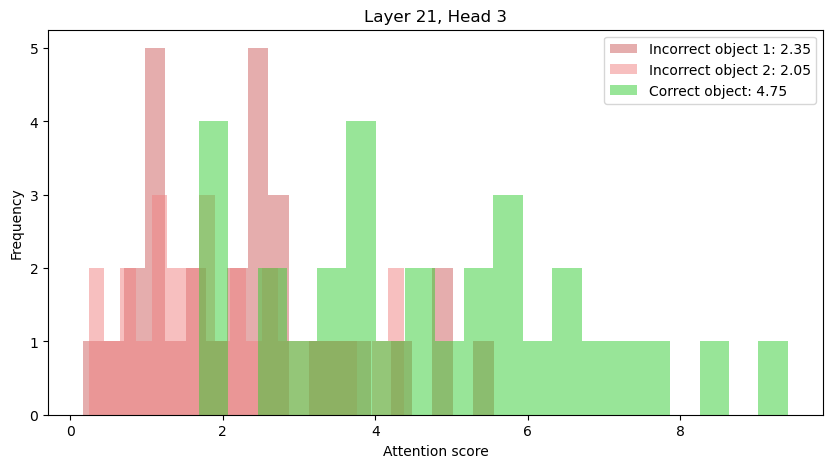

In [14]:
# Attention to objects in the context

correct_object_attn_scores = defaultdict(list)
incorrect_object_1_attn_scores = defaultdict(list)
incorrect_object_2_attn_scores = defaultdict(list)
self_attn_scores = defaultdict(list)
ablation_heads = [[14, 27], [11, 23], [12, 23]]

for layer, head in direct_logit_heads:
    attn_scores, value_vectors = analysis_utils.get_attn_scores(
        model,
        base_tokens,
        layer,
        ablation_heads=ablation_heads,
        last_token_pos=base_last_token_indices,
    )
    value_vectors_norm = torch.norm(value_vectors, dim=-1)
    attn_scores = einsum(
        value_vectors_norm,
        attn_scores,
        "batch k_seq_len n_heads, batch n_heads q_seq_len k_seq_len -> batch n_heads q_seq_len k_seq_len",
    )

    for bi in range(base_tokens.size(0)):
        correct_object = correct_answer_token[bi]
        incorrect_objects = incorrect_answer_token[bi]

        context = base_tokens[bi][: base_last_token_indices[bi] - 3]
        correct_object_pos_start = [
            pos for pos, token in enumerate(context) if token == correct_object
        ][0]
        correct_object_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > correct_object_pos_start)
        ][0]

        incorrect_obj_1_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[0]
        ][0]
        incorrect_obj_1_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_1_pos_start)
        ][0]

        incorrect_obj_2_pos_start = [
            pos for pos, token in enumerate(context) if token == incorrect_objects[1]
        ][0]
        incorrect_obj_2_pos_end = [
            pos
            for pos, token in enumerate(context)
            if ((token == 29892 or token == 29889) and pos > incorrect_obj_2_pos_start)
        ][0]

        self_attn_scores[(layer, head)].append(
            attn_scores[bi, head, base_last_token_indices[bi], base_last_token_indices[bi]].item()
        )
        correct_object_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    correct_object_pos_start:correct_object_pos_end,
                ]
            ).item()
        )
        incorrect_object_1_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_1_pos_start:incorrect_obj_1_pos_end,
                ]
            ).item()
        )
        incorrect_object_2_attn_scores[(layer, head)].append(
            torch.sum(
                attn_scores[
                    bi,
                    head,
                    base_last_token_indices[bi],
                    incorrect_obj_2_pos_start:incorrect_obj_2_pos_end,
                ]
            ).item()
        )

    # Plotting
    plt.figure(figsize=(10, 5))
    # plt.hist(self_attn_scores[(layer, head)], bins=20, alpha=0.5, label=f"Self: {round(np.mean(self_attn_scores[(layer, head)]), 2)}", color="red")
    plt.hist(
        incorrect_object_1_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 1: {round(np.mean(incorrect_object_1_attn_scores[(layer, head)]), 2)}",
        color="indianred",
    )
    plt.hist(
        incorrect_object_2_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Incorrect object 2: {round(np.mean(incorrect_object_2_attn_scores[(layer, head)]), 2)}",
        color="lightcoral",
    )
    plt.hist(
        correct_object_attn_scores[(layer, head)],
        bins=20,
        alpha=0.5,
        label=f"Correct object: {round(np.mean(correct_object_attn_scores[(layer, head)]), 2)}",
        color="limegreen",
    )
    plt.ylabel("Frequency")
    plt.xlabel("Attention score")
    # plt.xlim([0, 1])
    plt.title(f"Layer {layer}, Head {head}")
    plt.legend()

    #     plt.savefig(
    #         os.path.join(
    #             "result_plots",
    #             "alternate_format",
    #             "attn_score_of_logit_heads",
    #             "attn_scores_{}_{}.png".format(layer, head),
    #         ),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )
    plt.show()

### Activation Patching on Object Attender Heads

In [117]:
base_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the"
base_tokens = tokenizer(base_prompt, return_tensors="pt").input_ids.to(device)
last_base_token_pos = (
    tokenizer(base_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)
source_prompt = "Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the"
source_tokens = tokenizer.encode(source_prompt, return_tensors="pt").to(device)
last_source_token_pos = (
    tokenizer(source_prompt, return_tensors="pt").attention_mask.to(device).sum(dim=-1) - 1
)

In [118]:
ablation_heads = heads_influencing_object_value_fetcher_heads
modules = list(set([f"model.layers.{layer}.self_attn.o_proj" for layer, _ in ablation_heads]))

In [119]:
with torch.no_grad():
    with TraceDict(model, modules, retain_input=True) as source_cache:
        _ = model(source_tokens)

In [132]:
def patch_head_output(
    inputs=None, output=None, layer=None, heads=None, base_last=None, source_last=None
):
    input = inputs[0]
    # print(input.shape)
    input = rearrange(
        input,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )
    cache = rearrange(
        source_cache[layer].output,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    heads_at_curr_layer = [h for l, h in heads if l == int(layer.split(".")[2])]
    # print(heads_at_curr_layer, layer)

    for head in heads_at_curr_layer:
        input[0, base_last, head] = cache[0, source_last, head]

    input = rearrange(
        input,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        input, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    )

    return output

In [133]:
with torch.no_grad():
    with TraceDict(
        model,
        modules,
        retain_input=True,
        edit_output=partial(
            patch_head_output,
            heads=ablation_heads,
            base_last=last_base_token_pos,
            source_last=last_source_token_pos,
        ),
    ) as _:
        output = model(base_tokens)

In [134]:
logit, pred = torch.max(output.logits[0, -1], dim=-1)
print(f"{base_prompt}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")
print(f"{source_prompt}")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box X contains the: ' glass', 14.51
Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the


In [70]:
output = model(source_tokens)
pred = torch.argmax(output.logits[0, -1], dim=-1).item()
print(f"{source_prompt}: '{tokenizer.decode(pred)}'")

Box X contains the glass, Box T contains the train, Box A contains the ladybug. Box A contains the: ' lady'


### Patching Residual Stream

In [24]:
original = (
    "The bill is in Box X, the chemical is in Box T, the medicine is in Box A. Box E contains the"
)
original_tokens = tokenizer.encode(original, return_tensors="pt").to(device)
alternative = (
    "The apple is in Box A, the banana is in Box T, the bell is in Box X. Box X contains the"
)
alternative_tokens = tokenizer.encode(alternative, return_tensors="pt").to(device)

modules = [f"model.layers.{layer}" for layer in range(32)]

In [25]:
with TraceDict(model, modules) as cache:
    _ = model(alternative_tokens)

In [30]:
def patch_residual(output, layer):
    residual = cache[layer].output
    output[0][:, -1] = residual[0][:, -1]

    return output

In [31]:
for layer in range(32):
    with TraceDict(model, [f"model.layers.{layer}"], edit_output=patch_residual) as _:
        output = model(original_tokens)
    logit, pred = torch.max(output.logits[0, -1], dim=-1)
    print(f"Layer: {layer}: '{tokenizer.decode(pred)}', {round(logit.item(), 2)}")

Layer: 0: ' key', 13.33
Layer: 1: ' key', 13.32
Layer: 2: ' key', 13.33
Layer: 3: ' key', 13.33
Layer: 4: ' key', 13.34
Layer: 5: ' key', 13.33
Layer: 6: ' key', 13.33
Layer: 7: ' key', 13.32
Layer: 8: ' key', 13.37
Layer: 9: ' key', 13.38
Layer: 10: ' key', 13.41
Layer: 11: ' chemical', 13.33
Layer: 12: ' chemical', 13.4
Layer: 13: ' chemical', 13.86
Layer: 14: ' medicine', 15.16
Layer: 15: ' chemical', 14.88
Layer: 16: ' chemical', 15.37
Layer: 17: ' chemical', 15.01
Layer: 18: ' chemical', 14.65
Layer: 19: ' chemical', 14.5
Layer: 20: ' bell', 15.51
Layer: 21: ' bell', 15.67
Layer: 22: ' bell', 15.56
Layer: 23: ' bell', 15.66
Layer: 24: ' bell', 15.41
Layer: 25: ' bell', 15.37
Layer: 26: ' bell', 15.28
Layer: 27: ' bell', 15.32
Layer: 28: ' bell', 15.55
Layer: 29: ' bell', 15.52
Layer: 30: ' bell', 15.73
Layer: 31: ' bell', 16.24


The engine is in Box S, the machine is in Box L, the brain is in Box I. Box I contains the: ' brain', 12.91


## Attention Knockout

In [64]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

In [65]:
def intervention_wrapper(batch_size, seq_len, from_pos, to_pos):
    def attention_knockout(inputs, output, layer):
        if "norm" in layer:
            return output
        global queries, keys, attn_outputs
        n_heads = model.config.num_attention_heads
        d_model = model.config.hidden_size
        d_head = d_model // n_heads
        layer_index = int(layer.split(".")[4])

        if "q_proj" in layer:
            query = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            queries[layer_index] = query

        elif "k_proj" in layer:
            key = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            keys[layer_index] = key

        elif "v_proj" in layer:
            value = output.view(batch_size, seq_len, n_heads, d_head).transpose(1, 2)
            key = keys[layer_index]
            query = queries[layer_index]

            kv_seq_len = key.shape[-2]
            cos, sin = model.base_model.model.model.layers[layer_index].self_attn.rotary_emb(
                value, seq_len=kv_seq_len
            )
            positions = [i for i in range(seq_len)]
            positions = torch.tensor(positions).unsqueeze(0).repeat(batch_size, 1).to(device)
            query, key = apply_rotary_pos_emb(query, key, cos, sin, positions)

            attn_scores = einsum(
                key,
                query,
                "batch n_heads key_pos d_head, batch n_heads query_pos d_head -> batch n_heads query_pos key_pos",
            )
            attn_scores = attn_scores / math.sqrt(d_head)
            attn_scores = apply_causal_mask(attn_scores, layer, from_pos, to_pos)
            attn_scores = torch.softmax(attn_scores, dim=-1)
            attn_output = einsum(
                attn_scores,
                value,
                "batch n_heads query_pos key_pos, batch n_heads key_pos d_head -> batch query_pos n_heads d_head",
            )
            attn_output = attn_output.reshape(batch_size, seq_len, d_model)
            attn_outputs[layer_index] = attn_output

        elif "o_proj" in layer:
            attn_output = attn_outputs[layer_index]
            o_proj_weight = model.state_dict()[f"{layer}.weight"]
            output = einsum(
                attn_output,
                o_proj_weight,
                "batch seq_len d_model, hidden_size d_model -> batch seq_len hidden_size",
            )
            return output
        else:
            return output

    return attention_knockout

In [66]:
def compute_prev_query_box_pos(input_ids, last_token_index):
    query_box_token = input_ids[last_token_index - 2]
    prev_query_box_token_pos = (
        (input_ids[: last_token_index - 2] == query_box_token).nonzero().item()
    )
    return prev_query_box_token_pos

In [53]:
def compute_segments(inputs, correct_object_pos):
    segs = []
    segments = defaultdict(list)

    seg_end_pos = torch.cat([inputs.eq(29892).nonzero()[:, 1], inputs.eq(29889).nonzero()[:, 1]])
    for seg_idx in range(seg_end_pos.size(0)):
        segs.append(
            torch.arange(
                seg_end_pos[seg_idx - 1] + 1 if seg_idx > 0 else 1, seg_end_pos[seg_idx] + 1
            )
        )
    for seg in segs:
        if correct_object_pos in seg:
            segments["correct_obj"] = seg
        else:
            if "incorrect_obj_1" not in segments:
                segments["incorrect_obj_1"] = seg
            else:
                segments["incorrect_obj_2"] = seg

    return segments

In [54]:
def apply_causal_mask(attn_scores, layer, from_pos, to_pos):
    ignore = torch.tensor(torch.finfo(attn_scores.dtype).min)
    mask = torch.triu(
        torch.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device),
        diagonal=1,
    ).bool()
    attn_scores.masked_fill_(mask, ignore)

    # Attention knockout
    # layer_index = int(layer.split('.')[2])
    attn_scores[:, :, from_pos, to_pos] = ignore

    return attn_scores

In [56]:
accuracies = defaultdict(float)
comma_token = 29892
period_token = 29889
for knockout_layer in range(0, model.config.num_hidden_layers):
    modules = [
        [
            f"base_model.model.model.layers.{i}.self_attn.k_proj",
            f"base_model.model.model.layers.{i}.self_attn.q_proj",
            f"base_model.model.model.layers.{i}.self_attn.v_proj",
            f"base_model.model.model.layers.{i}.self_attn.o_proj",
        ]
        for i in range(knockout_layer, model.config.num_hidden_layers)
    ]

    modules = [item for sublist in modules for item in sublist]
    queries, keys, attn_outputs = {}, {}, {}

    model.eval()
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, input in tqdm(enumerate(tqdm(dataloader)), desc=f"{knockout_layer}"):
            for k, v in input.items():
                if v is not None and isinstance(v, torch.Tensor):
                    input[k] = v.to(model.device)

            batch_size, seq_len = input["input_ids"].shape
            prev_box_label_index = compute_prev_query_box_pos(
                input["input_ids"][0], input["last_token_indices"][0]
            )
            correct_obj_pos = prev_box_label_index - 5

            with TraceDict(
                model,
                modules,
                retain_output=True,
                edit_output=intervention_wrapper(
                    batch_size,
                    seq_len,
                    from_pos=input["last_token_indices"],
                    to_pos=correct_obj_pos,
                ),
            ) as _:
                outputs = model(input_ids=input["input_ids"])

            for bi in range(input["labels"].size(0)):
                label = input["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][input["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    accuracies[knockout_layer] = round(correct_count / total_count, 2)

    print(f"Knockout Starting Layer {knockout_layer} acc: {accuracies[knockout_layer]}")

  0%|          | 0/100 [00:00<?, ?it/s]100%|██████████| 100/100 [00:24<00:00,  4.01it/s]
0: 100it [00:24,  4.01it/s]


Knockout Starting Layer 0 acc: 0.82


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]
1: 100it [00:24,  4.03it/s]


Knockout Starting Layer 1 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
2: 100it [00:23,  4.18it/s]


Knockout Starting Layer 2 acc: 0.77


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]
3: 100it [00:23,  4.27it/s]


Knockout Starting Layer 3 acc: 0.76


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
4: 100it [00:23,  4.31it/s]


Knockout Starting Layer 4 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]
5: 100it [00:22,  4.47it/s]


Knockout Starting Layer 5 acc: 0.76


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]
6: 100it [00:22,  4.51it/s]


Knockout Starting Layer 6 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.60it/s]
7: 100it [00:21,  4.60it/s]


Knockout Starting Layer 7 acc: 0.79


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]
8: 100it [00:21,  4.70it/s]


Knockout Starting Layer 8 acc: 0.79


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]
9: 100it [00:20,  4.87it/s]


Knockout Starting Layer 9 acc: 0.76


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]
10: 100it [00:20,  4.94it/s]


Knockout Starting Layer 10 acc: 0.81


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]
11: 100it [00:19,  5.03it/s]


Knockout Starting Layer 11 acc: 0.8


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]
12: 100it [00:19,  5.14it/s]


Knockout Starting Layer 12 acc: 0.79


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]
13: 100it [00:19,  5.24it/s]


Knockout Starting Layer 13 acc: 0.81


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
14: 100it [00:18,  5.36it/s]


Knockout Starting Layer 14 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]
15: 100it [00:17,  5.68it/s]


Knockout Starting Layer 15 acc: 0.8


100%|██████████| 100/100 [00:17<00:00,  5.73it/s]
16: 100it [00:17,  5.73it/s]


Knockout Starting Layer 16 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]
17: 100it [00:16,  5.93it/s]


Knockout Starting Layer 17 acc: 0.85


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]
18: 100it [00:16,  6.11it/s]


Knockout Starting Layer 18 acc: 0.85


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]
19: 100it [00:15,  6.32it/s]


Knockout Starting Layer 19 acc: 0.84


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]
20: 100it [00:15,  6.50it/s]


Knockout Starting Layer 20 acc: 0.84


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]
21: 100it [00:14,  6.91it/s]


Knockout Starting Layer 21 acc: 0.83


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]
22: 100it [00:14,  7.05it/s]


Knockout Starting Layer 22 acc: 0.84


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]
23: 100it [00:13,  7.47it/s]


Knockout Starting Layer 23 acc: 0.84


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]
24: 100it [00:12,  7.69it/s]


Knockout Starting Layer 24 acc: 0.85


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]
25: 100it [00:12,  8.25it/s]


Knockout Starting Layer 25 acc: 0.85


26: 14it [00:01,  8.17it/s]:01<00:10,  8.55it/s]
 14%|█▍        | 14/100 [00:01<00:10,  8.16it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:42                                                                                   │
│                                                                                                  │
│   39 │   │   │   │   │   to_pos=correct_obj_pos                                                  │
│   40 │   │   │   │   ),                                                                          │
│   41 │   │   │   ) as _:                                                                         │
│ ❱ 42 │   │   │   │   outputs = model(input_ids=input["input_ids"])                               │
│   43 │   │   │                                                                                   │
│   44 │   │   │   for bi in range(input["labels"].size(0)):                                       │
│   45 │   │   │   │   label = input["labels"][bi]                                                 │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/peft/peft_model.py:857 in      │
│ forward                                                                                          │
│                                                                                                  │
│    854 │   │   │   │   │   **kwargs,                                                             │
│    855 │   │   │   │   )                                                                         │
│    856 │   │   │                                                                                 │
│ ❱  857 │   │   │   return self.base_model(                                                       │
│    858 │   │   │   │   input_ids=input_ids,                                                      │
│    859 │   │   │   │   attention_mask=attention_mask,                                            │
│    860 │   │   │   │   inputs_embeds=inputs_embeds,                                              │
│                                                                                                  │
│ /home/local_nikhil/.conda/envs/anima/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)    

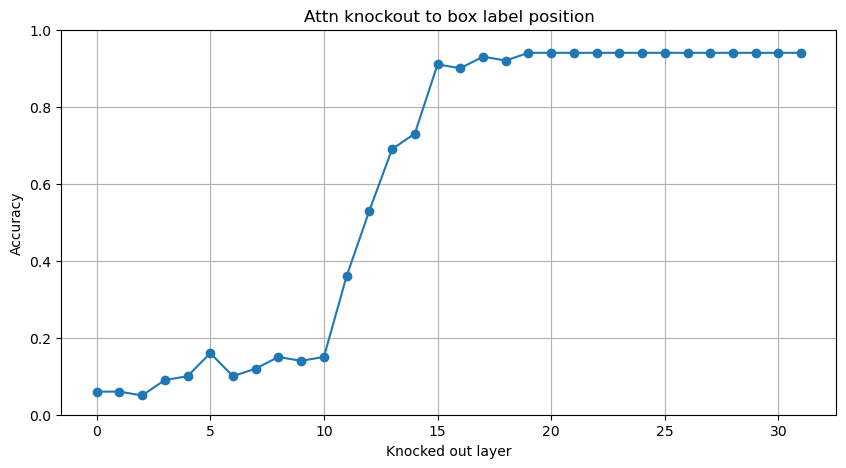

In [17]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker="o")
plt.xlabel("Knocked out layer")
plt.ylabel("Accuracy")
plt.title("Attn knockout to box label position")
plt.ylim([0, 1])
plt.grid()
plt.show()

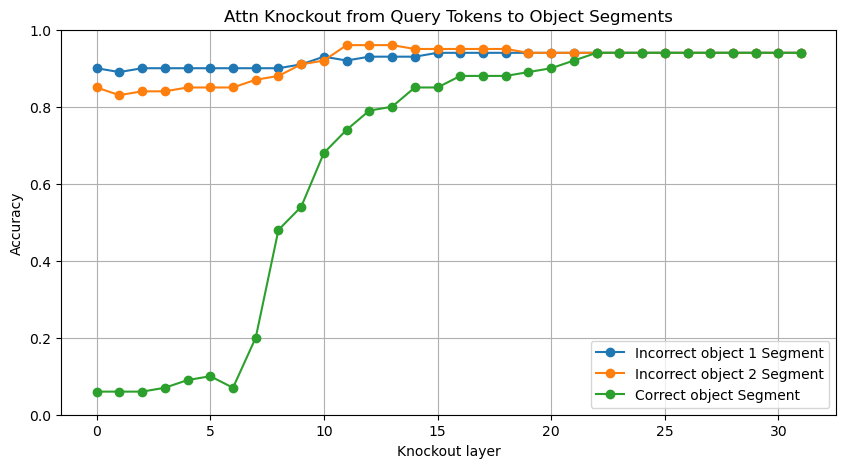

In [42]:
# plot accuracies for each knockout layer
plt.figure(figsize=(10, 5))
plt.plot(
    list(accuracies.keys()),
    [acc[1] for acc in accuracies.values()],
    label="Incorrect object 1 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[2] for acc in accuracies.values()],
    label="Incorrect object 2 Segment",
    marker="o",
)
plt.plot(
    list(accuracies.keys()),
    [acc[0] for acc in accuracies.values()],
    label="Correct object Segment",
    marker="o",
)
plt.title("Attn Knockout from Query Tokens to Object Segments")
plt.xlabel("Knockout layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

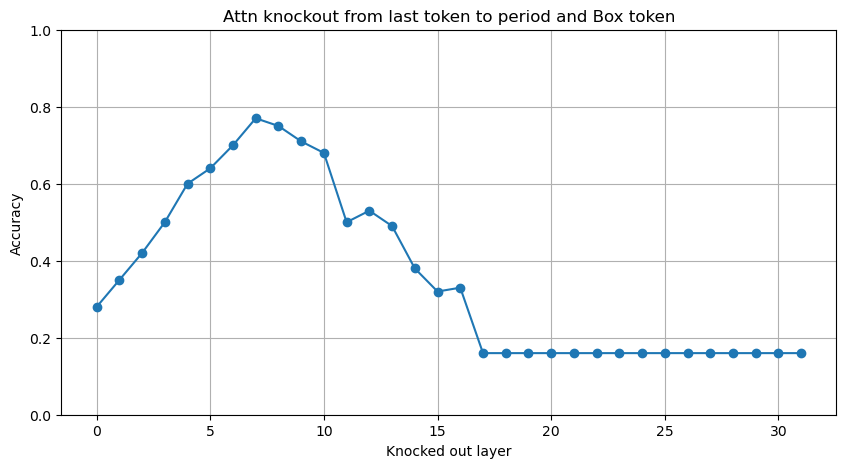

Text(0.5, 1.0, 'Attn Knockout from Query Tokens to Correct Object Segment')

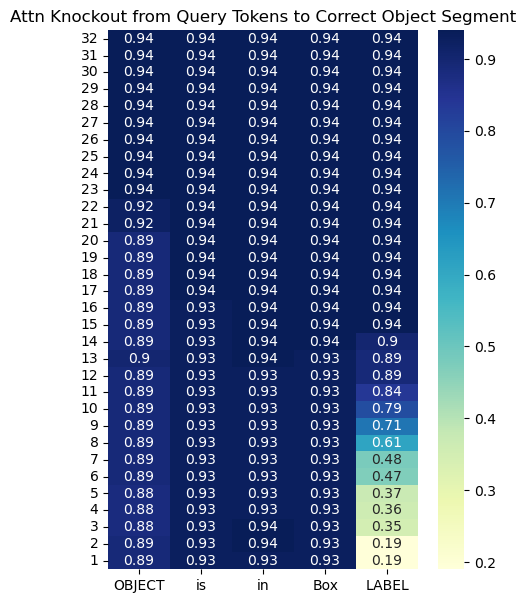

In [47]:
# Plot a heatmap of accuracies
accuracies_list = np.array(list(accuracies.values()))
accuracies_list = np.flip(accuracies_list, axis=0)

plt.figure(figsize=(5, 7))
sns.heatmap(
    accuracies_list,
    annot=True,
    cmap="YlGnBu",
    yticklabels=[i for i in range(32, 0, -1)],
    xticklabels=["OBJECT", "is", "in", "Box", "LABEL"],
)
plt.title("Attn Knockout from Query Tokens to Correct Object Segment")

## Evaluation Metrics

### Faithfulness

In [42]:
data_file = "./box_datasets/no_instructions/alternative/Random/7/train.jsonl"
object_file = "./box_datasets/filtered_objects_with_bnc_frequency.csv"
batch_size = 50

In [43]:
raw_data = generate_data_for_eval(
    tokenizer=tokenizer,
    num_samples=3500,
    data_file=data_file,
    num_boxes=7,
)

ablate_dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
    }
).with_format("torch")

print(f"Length of dataset: {len(ablate_dataset)}")

ablate_dataloader = DataLoader(ablate_dataset, batch_size=batch_size)

Length of dataset: 500


In [44]:
idx = 0
print(
    f"Prompt: {tokenizer.decode(dataset[idx]['input_ids'][:dataset[idx]['last_token_indices']+1])}"
)

Prompt: <s>The document is in Box X, the pot is in Box T, the magnet is in Box A, the game is in Box E, the bill is in Box M, the cross is in Box K, the map is in Box D. Box X contains the


In [45]:
if model.config.architectures[0] == "LlamaForCausalLM":
    modules = [f"model.layers.{layer}.self_attn.o_proj" for layer in range(32)]
else:
    modules = [f"base_model.model.model.layers.{layer}.self_attn.o_proj" for layer in range(32)]

mean_activations = {}
with torch.no_grad():
    # Assuming a single batch
    for _, output in tqdm(enumerate(tqdm(ablate_dataloader))):
        for k, v in output.items():
            if v is not None and isinstance(v, torch.Tensor):
                output[k] = v.to(model.device)

        with TraceDict(model, modules, retain_input=True) as cache:
            _ = model(output["input_ids"])

        for layer in modules:
            if "self_attn" in layer:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].input, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].input, dim=0)
            else:
                if layer in mean_activations:
                    mean_activations[layer] += torch.mean(cache[layer].output, dim=0)
                else:
                    mean_activations[layer] = torch.mean(cache[layer].output, dim=0)

        del cache
        torch.cuda.empty_cache()

    for layer in modules:
        mean_activations[layer] /= len(ablate_dataloader)

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
10it [00:20,  2.06s/it]


In [46]:
def mean_ablate(inputs, output, layer, circuit_components, mean_activations, input_tokens):
    if isinstance(inputs, tuple):
        inputs = inputs[0]

    if isinstance(output, tuple):
        output = output[0]

    inputs = rearrange(
        inputs,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    mean_act = rearrange(
        mean_activations[layer],
        "seq_len (n_heads d_head) -> 1 seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    last_pos = inputs.size(1) - 1
    for bi in range(inputs.size(0)):
        prev_query_box_pos = analysis_utils.compute_prev_query_box_pos(
            input_tokens[bi], input_tokens[bi].size(0) - 1
        )
        for token_pos in range(inputs.size(1)):
            if (
                token_pos != prev_query_box_pos
                and token_pos != last_pos
                and token_pos != last_pos - 2
                and token_pos != prev_query_box_pos + 1
            ):
                inputs[bi, token_pos, :] = mean_act[0, token_pos, :]
            elif token_pos == prev_query_box_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-1][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == prev_query_box_pos + 1:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == last_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[0][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]
            elif token_pos == last_pos - 2:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[0, token_pos, head_idx]

    inputs = rearrange(
        inputs,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        inputs, w_o, "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model"
    )

    return output

In [50]:
def eval(model, dataloader, modules, circuit_components, mean_activations):
    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, output in enumerate(tqdm(dataloader)):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)
    
            with TraceDict(
                model,
                modules,
                retain_input=True,
                edit_output=partial(
                    mean_ablate,
                    circuit_components=circuit_components,
                    mean_activations=mean_activations,
                    input_tokens=output["input_ids"],
                ),
            ) as _:
                outputs = model(output["input_ids"])
    
            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][output["last_token_indices"][bi]])
    
                if label == pred:
                    correct_count += 1
                # else:
                #     print(f"Label: {tokenizer.decode(label)}, Prediction: {tokenizer.decode(pred)}")
                total_count += 1
    
            del outputs
            torch.cuda.empty_cache()
    
    current_acc = round(correct_count / total_count, 2)
    print(f"Task accuracy: {current_acc}")
    return current_acc

In [ ]:
# [47, 15, 25, 10]
n_value_fetcher = 63
n_pos_trans = 15
n_pos_detect = 30
n_struct_read = 5

circuit_components = {}
circuit_components[0] = defaultdict(list)
circuit_components[2] = defaultdict(list)
circuit_components[-1] = defaultdict(list)
circuit_components[-2] = defaultdict(list)

root_path = "./new_pp_exps/post_submission/llama-7b"

path = root_path + "/direct_logit_heads.pt"
direct_logit_heads = analysis_utils.compute_topk_components(torch.load(path), k=n_value_fetcher, largest=False)

path = root_path + "/heads_affect_direct_logit.pt"
heads_affecting_direct_logit_heads = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_trans, largest=False
)

path = root_path + "/heads_at_query_box_pos.pt"
head_at_query_box_token = analysis_utils.compute_topk_components(
    torch.load(path), k=n_pos_detect, largest=False
)

path = root_path + "/heads_at_prev_query_box_pos.pt"
heads_at_prev_box_pos = analysis_utils.compute_topk_components(torch.load(path), k=n_struct_read, largest=False)

intersection = []
for head in direct_logit_heads:
    if head in heads_affecting_direct_logit_heads:
        intersection.append(head)

for head in intersection:
    direct_logit_heads.remove(head)

print(
    len(direct_logit_heads),
    len(heads_affecting_direct_logit_heads),
    len(head_at_query_box_token),
    len(heads_at_prev_box_pos),
)

for layer_idx, head in direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)

for layer_idx, head in heads_affecting_direct_logit_heads:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[0][layer].append(head)


for layer_idx, head in head_at_query_box_token:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[2][layer].append(head)


for layer_idx, head in heads_at_prev_box_pos:
    if model.config.architectures[0] == "LlamaForCausalLM":
        layer = f"model.layers.{layer_idx}.self_attn.o_proj"
    else:
        layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
    circuit_components[-1][layer].append(head)

for pos in circuit_components.keys():
    for layer_idx in circuit_components[pos].keys():
        circuit_components[pos][layer_idx] = list(set(circuit_components[pos][layer_idx]))

eval(model, dataloader, modules, circuit_components, mean_activations)

50 15 30 5


 10%|█         | 1/10 [00:06<00:56,  6.27s/it]